In [1]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "WESAD/S2/S2_E4_Data/ACC.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "orvile/wesad-wearable-stress-affect-detection-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:\n", df.head())

c:\Users\dmata\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First 5 records:
    1495437325.000000   1495437325.000000   1495437325.000000.1
0               32.0                32.0                  32.0
1               29.0                -6.0                  55.0
2               28.0                -6.0                  55.0
3               28.0                -6.0                  55.0
4               28.0                -6.0                  55.0


In [2]:
import pickle
import numpy as np
import pandas as pd
from scipy.signal import resample
import kagglehub

# -------------------------
# LISTA DE SUJETOS A CARGAR
# -------------------------
subjects = ["S2", "S3", "S4", "S5", "S6", "S7",
            "S8", "S9", "S10", "S11", "S13",
            "S14", "S15", "S16", "S17"]

def load_subject(subject):
    """Carga un sujeto, procesa sus señales y retorna un DataFrame."""
    print(f"Procesando {subject} ...")

    # Descargar archivo pkl de KaggleHub
    path = kagglehub.dataset_download(
        "orvile/wesad-wearable-stress-affect-detection-dataset",
        f"WESAD/{subject}/{subject}.pkl"
    )

    with open(path, "rb") as f:
        data = pickle.load(f, encoding="latin1")

    # Señales del reloj
    acc  = np.array(data["signal"]["wrist"]["ACC"])     # Nx3 @32Hz
    bvp  = np.array(data["signal"]["wrist"]["BVP"]).squeeze()   # Nx1 @64Hz
    eda  = np.array(data["signal"]["wrist"]["EDA"]).squeeze()   # Nx1 @4Hz
    temp = np.array(data["signal"]["wrist"]["TEMP"]).squeeze()  # Nx1 @4Hz

    labels = np.array(data["label"])  # 700Hz
    L = len(labels)

    # Re-sample todas las señales a 700Hz
    acc_rs  = resample(acc,  L)
    bvp_rs  = resample(bvp,  L)
    eda_rs  = resample(eda,  L)
    temp_rs = resample(temp, L)

    # Solo estrés/no estrés
    stress_bin = np.where(labels == 2, 1, 0)

    df = pd.DataFrame({
        "subject": subject,
        "acc_x": acc_rs[:, 0],
        "acc_y": acc_rs[:, 1],
        "acc_z": acc_rs[:, 2],
        "bvp":   bvp_rs,
        "eda":   eda_rs,
        "temp":  temp_rs,
        "stress": stress_bin
    })

    return df


# --------------------------------------------
# Cargar y unir TODOS los sujetos en un dataset
# --------------------------------------------
all_dfs = []

for sbj in subjects:
    try:
        df = load_subject(sbj)
        all_dfs.append(df)
    except Exception as e:
        print(f"Error en {sbj}: {e}")

df_full = pd.concat(all_dfs, ignore_index=True)

print("\nDataset combinado listo!")
print(df_full.shape)
df_full.head()


Procesando S2 ...
Procesando S3 ...
Procesando S4 ...
Procesando S5 ...
Procesando S6 ...
Procesando S7 ...
Procesando S8 ...
Procesando S9 ...
Procesando S10 ...
Procesando S11 ...
Procesando S13 ...
Procesando S14 ...
Procesando S15 ...
Procesando S16 ...
Procesando S17 ...

Dataset combinado listo!
(60807600, 8)


,subject,acc_x,acc_y,acc_z,bvp,eda,temp,stress
0,S2,62.000000,-21.000000,107.000000,-59.370000,1.138257,35.410000,0
1,S2,62.307282,-21.156211,109.270362,-63.580766,1.142849,35.414642,0
2,S2,62.639848,-21.033768,111.011770,-66.580843,1.147382,35.419221,0
3,S2,62.995836,-20.638036,112.206895,-68.365462,1.151857,35.423735,0
4,S2,63.372326,-19.977788,112.844950,-68.985094,1.156272,35.428185,0


In [3]:
def get_stress_segments(df):
    """
    Retorna únicamente las filas donde stress == 1.
    """
    return df[df["stress"] == 1].reset_index(drop=True)
df_stress = get_stress_segments(df_full)
print(df_stress.head())
print(df_stress.shape)


  subject      acc_x      acc_y      acc_z         bvp       eda       temp  \
0      S2  13.439926 -52.379183  13.541135 -241.017702  0.775691  34.069856   
1      S2  13.828004 -52.455848  13.466781 -235.157796  0.775715  34.069852   
2      S2  14.209912 -52.532774  13.392612 -229.384873  0.775741  34.069848   
3      S2  14.582169 -52.608284  13.320201 -223.701984  0.775767  34.069844   
4      S2  14.941483 -52.680771  13.251144 -218.111837  0.775796  34.069840   

   stress  
0       1  
1       1  
2       1  
3       1  
4       1  
(6976201, 8)


In [4]:
summary(X)


NameError: name 'summary' is not defined

In [ ]:
import numpy as np
import pandas as pd

def window_reduce(df, hz=700, window_seconds=1):
    window = hz * window_seconds

    # dejar solo columnas NUMÉRICAS
    df_num = df.select_dtypes(include=[np.number])

    # cortar exceso para que sea divisible
    usable = (len(df_num) // window) * window
    df_num = df_num.iloc[:usable]

    # agrupar por ventana
    df_windowed = df_num.groupby(df_num.index // window).mean()

    # etiqueta binaria: basta un 1 dentro de la ventana
    df_windowed["stress"] = (
        df_num["stress"].groupby(df_num.index // window).max()
    )

    return df_windowed

df_reduced = window_reduce(df_full)

print(df_reduced.shape)
df_reduced


(86868, 7)


,acc_x,acc_y,acc_z,bvp,eda,temp,stress
0,51.976955,14.231976,28.649323,31.610494,1.068864,35.424470,0
1,55.877680,17.799241,24.395516,-16.107955,0.943409,35.411521,0
2,53.857164,22.171009,23.503597,-23.577625,1.155373,35.410588,0
3,53.384052,20.450312,27.180465,23.834969,1.292975,35.412379,0
4,53.785876,20.282777,26.803075,-10.903197,1.251165,35.428338,0
...,...,...,...,...,...,...,...
86863,-58.494999,9.180915,-5.010963,-4.118116,0.851749,31.832497,0
86864,-53.270878,-36.357195,-4.146985,-2.275416,0.823334,31.830760,0
86865,-52.473065,-37.917879,-5.222609,-0.784753,0.808060,31.813099,0
86866,-52.119191,-38.161129,-4.022418,6.420120,0.794579,31.812974,0


In [ ]:
print(df_reduced["stress"].value_counts())


stress
0    76887
1     9981
Name: count, dtype: int64


Procesando S2 ...
Procesando S3 ...
Procesando S4 ...
Procesando S5 ...
Procesando S6 ...
Procesando S7 ...
Procesando S8 ...
Procesando S9 ...
Procesando S10 ...
Procesando S11 ...
Procesando S13 ...
Procesando S14 ...
Procesando S15 ...
Procesando S16 ...
Procesando S17 ...
Dataset reducido: (86868, 7)
Distribución de clases:
stress
0    76887
1     9981
Name: count, dtype: int64

Train shape: (69494, 6), Test shape: (17374, 6)


c:\Users\dmata\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:22:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\dmata\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.23796 | test_auc: 0.96867 |  0:00:05s
epoch 1  | loss: 0.13804 | test_auc: 0.97837 |  0:00:10s
epoch 2  | loss: 0.12094 | test_auc: 0.98456 |  0:00:16s
epoch 3  | loss: 0.11005 | test_auc: 0.98814 |  0:00:21s
epoch 4  | loss: 0.10256 | test_auc: 0.98888 |  0:00:27s
epoch 5  | loss: 0.09702 | test_auc: 0.98904 |  0:00:33s
epoch 6  | loss: 0.09531 | test_auc: 0.98966 |  0:00:39s
epoch 7  | loss: 0.09025 | test_auc: 0.98916 |  0:00:44s
epoch 8  | loss: 0.08933 | test_auc: 0.99173 |  0:00:50s
epoch 9  | loss: 0.08324 | test_auc: 0.99202 |  0:00:56s
epoch 10 | loss: 0.08633 | test_auc: 0.99183 |  0:01:01s
epoch 11 | loss: 0.07797 | test_auc: 0.99325 |  0:01:07s
epoch 12 | loss: 0.07895 | test_auc: 0.994   |  0:01:13s
epoch 13 | loss: 0.07502 | test_auc: 0.99348 |  0:01:18s
epoch 14 | loss: 0.07842 | test_auc: 0.99259 |  0:01:24s
epoch 15 | loss: 0.07409 | test_auc: 0.99357 |  0:01:30s
epoch 16 | loss: 0.07023 | test_auc: 0.99428 |  0:01:36s
epoch 17 | loss: 0.06854 | test

c:\Users\dmata\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



COMPARACIÓN DE MODELOS - CLASIFICACIÓN DE ESTRÉS (WESAD)
                Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Train Time (s)  Predict Time (s)
         Random Forest  0.995338   0.985794 0.973447  0.979582 0.999714        1.033195          0.083615
               XGBoost  0.994590   0.974078 0.978958  0.976512 0.999628        0.129270          0.006462
TabNet (Deep Learning)  0.982330   0.891153 0.963928  0.926113 0.996765      268.750515          0.920548

ANÁLISIS COMPARATIVO
• Mejor Accuracy: Random Forest (0.9953)
• Mejor F1-Score: Random Forest (0.9796)
• Mejor ROC-AUC: Random Forest (0.9997)

• Modelo más rápido en entrenamiento: XGBoost
• Modelo más rápido en predicción: XGBoost


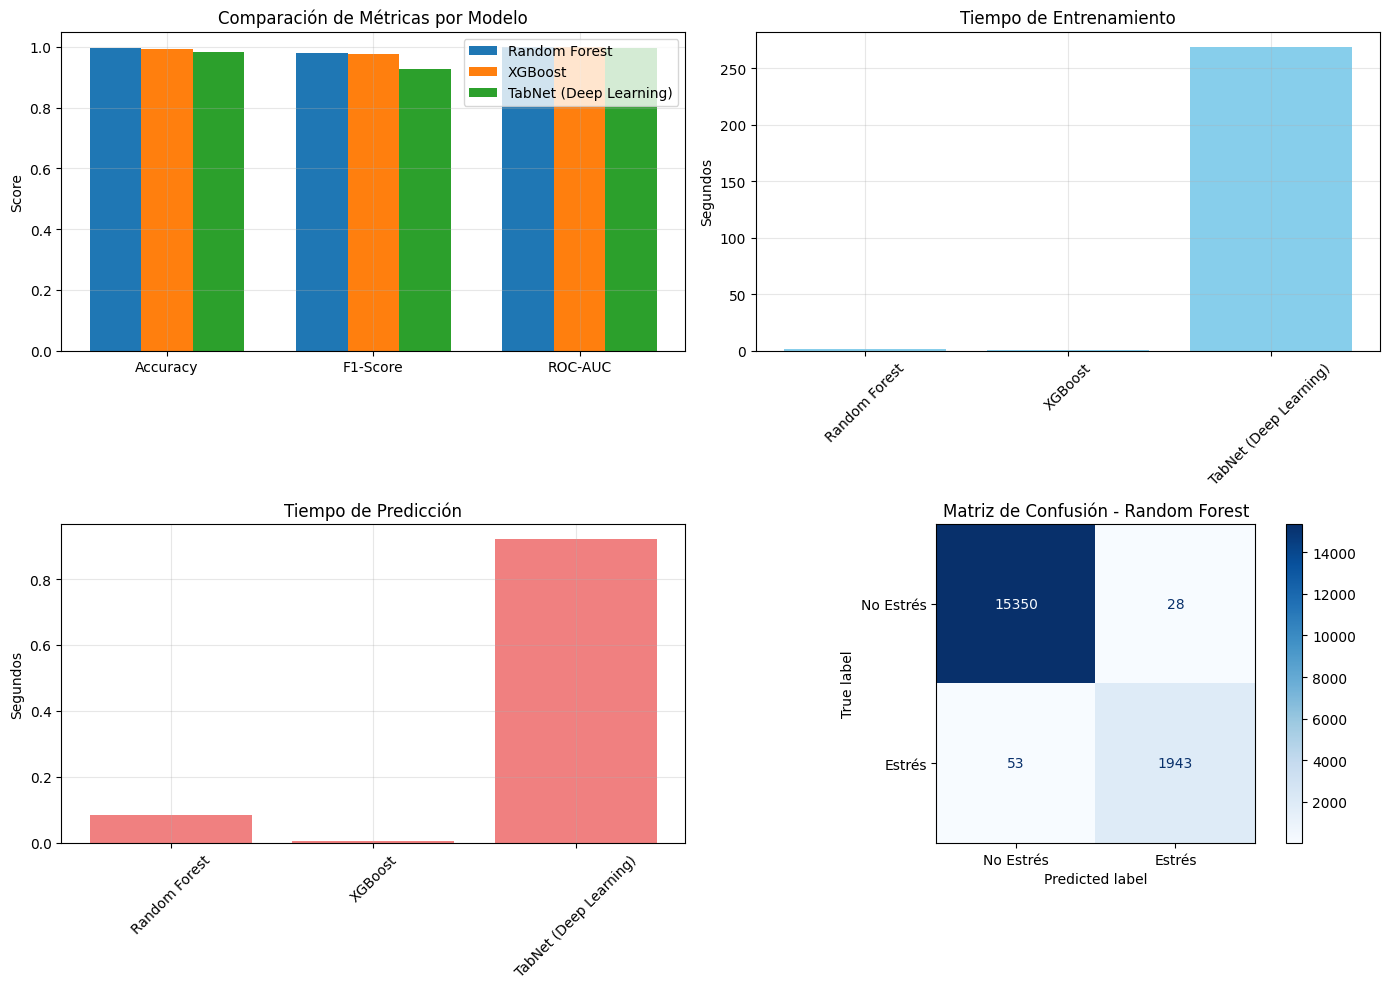

In [ ]:

# Carga y preparacion de los datos

import pickle
import numpy as np
import pandas as pd
from scipy.signal import resample
import kagglehub

subjects = ["S2", "S3", "S4", "S5", "S6", "S7",
            "S8", "S9", "S10", "S11", "S13",
            "S14", "S15", "S16", "S17"]

def load_subject(subject):
    print(f"Procesando {subject} ...")
    path = kagglehub.dataset_download(
        "orvile/wesad-wearable-stress-affect-detection-dataset",
        f"WESAD/{subject}/{subject}.pkl"
    )
    
    with open(path, "rb") as f:
        data = pickle.load(f, encoding="latin1")
    
    acc  = np.array(data["signal"]["wrist"]["ACC"])
    bvp  = np.array(data["signal"]["wrist"]["BVP"]).squeeze()
    eda  = np.array(data["signal"]["wrist"]["EDA"]).squeeze()
    temp = np.array(data["signal"]["wrist"]["TEMP"]).squeeze()
    labels = np.array(data["label"])
    L = len(labels)
    
    # Resample a 700Hz
    acc_rs  = resample(acc, L)
    bvp_rs  = resample(bvp, L)
    eda_rs  = resample(eda, L)
    temp_rs = resample(temp, L)
    
    stress_bin = np.where(labels == 2, 1, 0)
    
    df = pd.DataFrame({
        "subject": subject,
        "acc_x": acc_rs[:, 0],
        "acc_y": acc_rs[:, 1],
        "acc_z": acc_rs[:, 2],
        "bvp": bvp_rs,
        "eda": eda_rs,
        "temp": temp_rs,
        "stress": stress_bin
    })
    
    return df

def window_reduce(df, hz=700, window_seconds=1):
    window = hz * window_seconds
    df_num = df.select_dtypes(include=[np.number])
    usable = (len(df_num) // window) * window
    df_num = df_num.iloc[:usable]
    df_windowed = df_num.groupby(df_num.index // window).mean()
    df_windowed["stress"] = df_num["stress"].groupby(df_num.index // window).max()
    return df_windowed

# Cargar todos los sujetos
all_dfs = []
for sbj in subjects:
    try:
        df = load_subject(sbj)
        all_dfs.append(df)
    except Exception as e:
        print(f"Error en {sbj}: {e}")

df_full = pd.concat(all_dfs, ignore_index=True)

# Reducir ventanas
df_reduced = window_reduce(df_full)
print(f"Dataset reducido: {df_reduced.shape}")
print("Distribución de clases:")
print(df_reduced["stress"].value_counts())

# Preparacion de datos para el modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar características y objetivo
X = df_reduced.drop("stress", axis=1)
y = df_reduced["stress"]

# Escalar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")

# 4. MODELOS TRADICIONALES (Machine Learning)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    predict_time = time.time() - start_time
    
    results = {
        "Modelo": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None,
        "Train Time (s)": train_time,
        "Predict Time (s)": predict_time
    }
    return results

# Entrenar modelos tradicionales
traditional_models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
}

traditional_results = []
for name, model in traditional_models.items():
    results = evaluate_model(model, name, X_train, X_test, y_train, y_test)
    traditional_results.append(results)

# 5. MODELO DEEP LEARNING - TabNet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# Configurar TabNet
tabnet_model = TabNetClassifier(
    n_d=64,  # Dimensión de la capa de predicción
    n_a=64,  # Dimensión de la capa de atención
    n_steps=5,  # Pasos de atención
    gamma=1.5,  # Factor de regularización
    lambda_sparse=1e-3,  # Regularización de esparsidad
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type="entmax",  # "sparsemax" o "entmax"
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1,
    device_name='cuda' if torch.cuda.is_available() else 'cpu'
)

# Entrenar TabNet
start_time = time.time()
tabnet_model.fit(
    X_train=X_train, y_train=y_train.values,
    eval_set=[(X_test, y_test.values)],
    eval_name=['test'],
    eval_metric=['auc'],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)
tabnet_train_time = time.time() - start_time

# Predecir con TabNet
start_time = time.time()
y_pred_tabnet = tabnet_model.predict(X_test)
y_pred_proba_tabnet = tabnet_model.predict_proba(X_test)[:, 1]
tabnet_predict_time = time.time() - start_time

# Evaluar TabNet
tabnet_results = {
    "Modelo": "TabNet (Deep Learning)",
    "Accuracy": accuracy_score(y_test, y_pred_tabnet),
    "Precision": precision_score(y_test, y_pred_tabnet, zero_division=0),
    "Recall": recall_score(y_test, y_pred_tabnet, zero_division=0),
    "F1-Score": f1_score(y_test, y_pred_tabnet, zero_division=0),
    "ROC-AUC": roc_auc_score(y_test, y_pred_proba_tabnet),
    "Train Time (s)": tabnet_train_time,
    "Predict Time (s)": tabnet_predict_time
}

# COMPARAR RESULTADOS
import pandas as pd

# Combinar resultados
all_results = traditional_results + [tabnet_results]
results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("COMPARACIÓN DE MODELOS - CLASIFICACIÓN DE ESTRÉS (WESAD)")
print("="*80)
print(results_df.to_string(index=False))

# ANÁLISIS COMPARATIVO
print("\n" + "="*80)
print("ANÁLISIS COMPARATIVO")
print("="*80)

# Mejor modelo por métrica
for metric in ["Accuracy", "F1-Score", "ROC-AUC"]:
    best_model = results_df.loc[results_df[metric].idxmax()]
    print(f"• Mejor {metric}: {best_model['Modelo']} ({best_model[metric]:.4f})")

# Comparación de tiempos
print(f"\n• Modelo más rápido en entrenamiento: {results_df.loc[results_df['Train Time (s)'].idxmin()]['Modelo']}")
print(f"• Modelo más rápido en predicción: {results_df.loc[results_df['Predict Time (s)'].idxmin()]['Modelo']}")

# VISUALIZACIÓ
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Comparación de métricas principales
metrics_to_plot = ['Accuracy', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (idx, row) in enumerate(results_df.iterrows()):
    values = [row[m] if row[m] is not None else 0 for m in metrics_to_plot]
    axes[0, 0].bar(x + i*width - width, values, width, label=row['Modelo'])

axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Comparación de Métricas por Modelo')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_to_plot)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Tiempos de entrenamiento
axes[0, 1].bar(results_df['Modelo'], results_df['Train Time (s)'], color='skyblue')
axes[0, 1].set_ylabel('Segundos')
axes[0, 1].set_title('Tiempo de Entrenamiento')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Tiempos de predicción
axes[1, 0].bar(results_df['Modelo'], results_df['Predict Time (s)'], color='lightcoral')
axes[1, 0].set_ylabel('Segundos')
axes[1, 0].set_title('Tiempo de Predicción')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 4: Matriz de confusión del mejor modelo
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Seleccionar mejor modelo por F1-Score
best_model_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Modelo']

if best_model_name == "TabNet (Deep Learning)":
    y_pred_best = y_pred_tabnet
elif best_model_name == "Random Forest":
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred_best = model.predict(X_test)
else:  # XGBoost
    model = XGBClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred_best = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Estrés', 'Estrés'])
disp.plot(ax=axes[1, 1], cmap='Blues')
axes[1, 1].set_title(f'Matriz de Confusión - {best_model_name}')

plt.tight_layout()
plt.show()
